In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl

import rff
import koopman

In [2]:
# Function to generate realizations:
def euler_sde(F, dt, x0, nsim, T, sigma=1.0):
    tvec = np.arange(0, T, dt)
    nt = tvec.shape[0]
    X = np.zeros((nsim, nt))
    X[:, 0] = x0
    for ii in range(1, nt):
        X[:, ii] = X[:, ii-1] + F(X[:, ii-1]) * dt + np.sqrt(dt)*sigma*np.random.randn(nsim)

    return tvec, X

### Generate long Simulation for Training

Text(0.5, 0, '$t$')

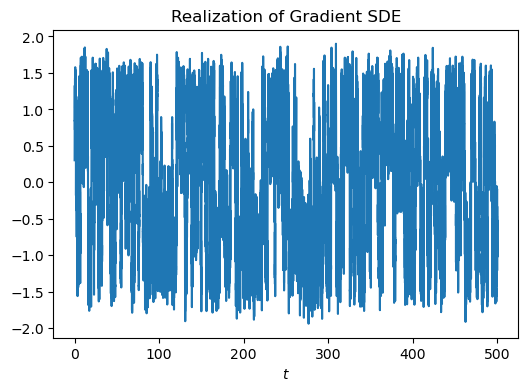

In [3]:
dt = 1e-2
T = 500.0
nsim = 1
sigma = np.sqrt(2)
x0 = np.random.rand(nsim)

F = lambda x: -4 * (x**2 - 1.0) * x
tvec, BX = euler_sde(F, dt, x0, nsim, T, sigma=sigma)

plt.figure(figsize=(6, 4))
plt.plot(tvec, BX.T)
plt.title("Realization of Gradient SDE")
plt.xlabel(r"$t$")

### Define Basis Set
We choose a basis set of random Fourier features (RFF):
$$ \phi_i (x) = \exp(i\omega_i^\top x),$$
where $\omega_i$ are random frequencies.

In [4]:
# Kernel bandwidth:
sigma = 1.0
# Feature numbers:
p = 100
# Regularization tolerance:
tol = 1e-4
# Lag time:
lag  = 20

In [6]:
""" Model Training """
Omega = rff.sample_rff_gaussian(1, p, sigma)
Phi = rff.RFF_Finite(Omega)
""" Learn Koopman model: """
print("Fitting Koopman model...")
X = BX[:, :-lag]
Y = BX[:, lag:]
K = koopman.koopman_matrix(X.astype(complex),Y.astype(complex), Phi, tol)
print(K.shape)

Fitting Koopman model...
(100, 100)


Text(0.5, 1.0, 'Leading Eigenfunctions of K')

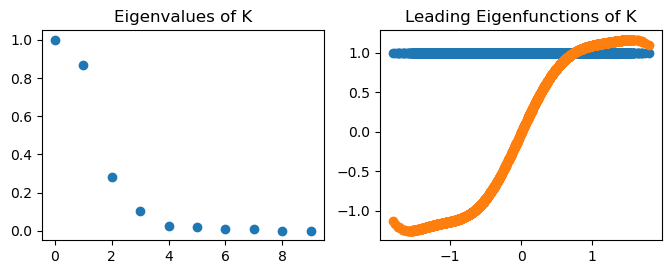

In [8]:
# Compute eigenvalues of the Koopman matrix:
d, V = scl.eig(K)
ind = np.argsort(d)[::-1]
d = np.real(d[ind])
V = V[:, ind]

# Evaluate eigenfunctions on subset of the data:
PhiX = Phi(X)
W = np.real(np.dot(V[:, :2].conj().T, PhiX))
for ii in range(2):
    W[ii, :] /= np.sqrt(np.mean(W[ii, :]**2))

plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plt.plot(d[:10], "o")
plt.title("Eigenvalues of K")

plt.subplot(2, 2, 2)
plt.scatter(X[0, ::20], np.real(W[0, ::20]))
plt.scatter(X[0, ::20], np.real(W[1, ::20]))
plt.title("Leading Eigenfunctions of K")

In [ ]:
print(-dt*lag / np.log(d[:10]))